In [1]:
# The program does some simple analysis on the description of houses
# to examine how hard it is to extract the desired features.
import re
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import operator

# read the dataset and get the desired subset 
temp = pd.read_csv('MLS_LISTING.csv')
data = temp[['public_remarks']].copy()   # get the column that has the descriptions
data['public_remarks'] = data['public_remarks'].astype(str)        # transform all values (including None) to string
data['public_remarks'] = data.apply(lambda x: x['public_remarks'].lower().replace(',', ' ').replace('.', ' '), axis=1)   # lower case the descriptions
data['word_count'] = data.apply(lambda x: len(x['public_remarks'].split()), axis=1)   # counting the words

/Users/lexingtong/.conda/envs/BigGorilla/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,30,32,34,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## How long are the house descriptions?

The average description is of length 82


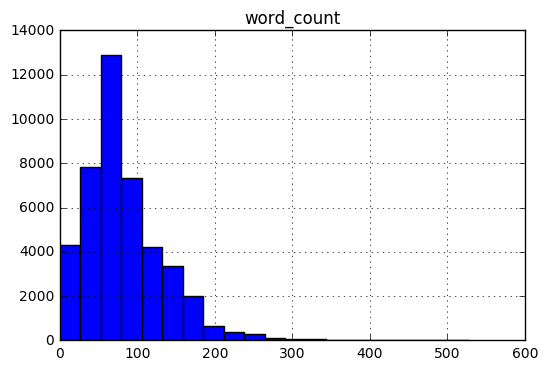

In [2]:
data[['word_count']].hist(bins=20)
print 'The average description is of length {}'.format(sum(data['word_count'])/len(data))

## How often attribute names are mentioned?

In [3]:
feature_values = {}
feature_values['style'] = ['a-frame', 'art deco', 'arts & crafts', 'barn type', 'brown shingle',
                           'bungalow', 'cabin', 'cape cod', 'chalet', 'colonial', 'contemporary',
                           'cottage', 'cottage/bungalow', 'country english', 'craftsman', 'custom',
                           'dome', 'edwardian', 'eichler', 'english', 'farm house', 'farmhouse',
                           'fixer-handyman special', 'flat', 'french', 'french country',
                           'french provincial', 'french/norman', 'georgian', 'log', 'luxury', 'macgregor',
                           'manufactured', 'manufactured housing', 'marina', 'mediterranean',
                           'modern/high tech', 'modern/hi-tech', 'modular/mobile', 'normandy', 'prairie',
                           'ranch', 'redwood glass', 'rustic', 'spanish', 'spanish/mediterr', 'townhome',
                           'tract', 'traditional', 'tudor', 'victorian', 'vintage', 'yurt']
feature_values['view'] = ['bay', 'bridge', 'canyon', 'city', 'downtown', 'forest', 'garden', 'golf course',
                          'greenbelt', 'hills', 'lake', 'lights', 'mountains', 'neighborhood', 'ocean', 'panoramic',
                          'park', 'partial', 'pasture', 'ridge', 'valley', 'vineyard', 'water', 'woods']
feature_values['floor'] = ['adobe', 'bamboo', 'brick', 'carpet', 'ceramic tile', 'clay', 'concrete',
                           'concrete slab', 'cork', 'granite', 'hardwood', 'hardwood floors',
                           'hardwood flrs throughout', 'laminate', 'laminated', 'linoleum',
                           'linoleum/vinyl', 'marble', 'natural fiber carpet', 'none', 'other',
                           'other-attch', 'other-rmks', 'painted/stained', 'parquet', 'partial carpet',
                           'partial hardwood', 'partially carpeted', 'pavers', 'reclaimed', 'recycled carpet',
                           'see remarks', 'sheet vinyl', 'simulated wood', 'slate', 'softwood',
                           'stained concrete', 'stamped', 'stone', 'stone (marble)', 'stone/travertine',
                           'terrazzo', 'tile', 'vinyl', 'vinyl tile', 'wall to wall carpet',
                           'wall to wall carpeting', 'wall-to-wall carpet', 'wood', 'wood laminate',
                           'wood under carpet']

In [4]:
print 'Total number of descriptions is {}'.format(len(data))
feature_count = {}
for feature in feature_values:
    feature_count[feature] = sum(data.apply(lambda x: feature in x['public_remarks'], axis=1))
    print '"{}" appears in {} descriptions'.format(feature, feature_count[feature])

Total number of descriptions is 43548
"style" appears in 3286 descriptions
"floor" appears in 22951 descriptions
"view" appears in 8115 descriptions


## How is the word that appears right before the feature's name?

In [5]:
# the function returns the word before 'keyword' in the 'text'
def before_token(text, keyword):
    try:
        tokens = text.split()
        index = tokens.index(keyword)
        return tokens[index - 1]
    except ValueError:
        return None

for feature in feature_values:
    data['before_' + feature] = data.apply(lambda x: before_token(x['public_remarks'], feature), axis=1)

#### what are the top words that appear before each feature?

In [6]:
for feature in feature_values:
    print 'The top 30 words appearing before "{}" are'.format(feature)
    print sorted(data['before_' + feature].value_counts()[:30].to_dict().items(),
                 key=operator.itemgetter(1), reverse=True)
    print '--------'

The top 30 words appearing before "style" are
[('ranch', 334), ('resort', 237), ('craftsman', 115), ('colonial', 66), ('cape', 45), ('cottage', 41), ('modern', 37), ('cod', 37), ('and', 36), ('country', 35), ('in', 31), ('mediterranean', 28), ('townhouse', 28), ('shaker', 28), ('traditional', 27), ('spanish', 26), ('contemporary', 25), ('european', 25), ('galley', 24), ('loft', 23), ('life', 21), ('&', 17), ('tudor', 17), ('bungalow', 17), ('the', 17), ('gourmet', 16), ('with', 14), ('victorian', 13), ('of', 13), ('farm', 12)]
--------
The top 30 words appearing before "floor" are
[('open', 3272), ('first', 1797), ('main', 1252), ('1st', 818), ('2nd', 545), ('second', 510), ('tile', 254), ('split', 227), ('top', 168), ('spacious', 168), ('great', 158), ('ground', 139), ('hardwood', 134), ('3rd', 121), ('the', 104), ('concept', 98), ('wood', 89), ('third', 88), ('bedroom', 82), ('with', 79), ('one', 77), ('and', 68), ('flowing', 60), ('new', 57), ('tiled', 49), ('laminate', 47), ('flexi

#### How often the word right before the feature's name is a valid value for the feature?

In [7]:
for feature in feature_values:
    print 'The word before "{}" is valid in {} instances out of {}'.format(
        feature, sum(data.apply(lambda x: x['before_' + feature] in feature_values[feature], axis=1)), 
        feature_count[feature]) 

The word before "style" is valid in 788 instances out of 3286
The word before "floor" is valid in 654 instances out of 22951
The word before "view" is valid in 451 instances out of 8115


#### How often a feature value appears in the description?

In [8]:
# the function returns true if any of the words in the 'keyword_list' is present in the text
def has_any(text, keyword_list):
    tokens = text.split()
    for keyword in keyword_list:
        if keyword in tokens: return True
    return False
        
for feature in feature_values:
    print 'A possible value for feature "{}" appears in {} instances.'.format(
        feature, sum(data.apply(lambda x: has_any(x['public_remarks'], feature_values[feature]), axis=1)))

A possible value for feature "style" appears in 15100 instances.
A possible value for feature "floor" appears in 24150 instances.
A possible value for feature "view" appears in 19490 instances.


#### How often a possible value for a feature co-occurs with the feature name?

In [9]:
# the function returns true if any of the words in the 'keyword_list' co-occur with feature in the text
def cooccurs(text, keyword_list, feature):
    tokens = text.split()
    if feature not in tokens: return False
    for keyword in keyword_list:
        if keyword in tokens: return True
    return False

for feature in feature_values:
    print 'A possible value for feature "{}" co-occurs with feature\'s name in {} instances.'.format(
        feature, sum(data.apply(lambda x: cooccurs(x['public_remarks'], feature_values[feature], feature), axis=1)))

A possible value for feature "style" co-occurs with feature's name in 1469 instances.
A possible value for feature "floor" co-occurs with feature's name in 9119 instances.
A possible value for feature "view" co-occurs with feature's name in 1897 instances.


## What can we say about "remodel"?

In [10]:
remodel_count = sum(data.apply(lambda x: 'remodel' in x['public_remarks'] or
                                        'remodeled' in x['public_remarks'], axis=1))
print '"remodel|remodeled" appears in {} descriptions'.format(remodel_count)

"remodel|remodeled" appears in 3129 descriptions


In [11]:
# the function returns the k words after 'keyword' in the 'text'
def after_token(text, keyword):
    try:
        tokens = text.split()
        index = tokens.index(keyword)
        return tokens[index + 1]
    except ValueError:
        return None
    except IndexError:
        return None

data['after_remodel'] = data.apply(lambda x: after_token(x['public_remarks'], 'remodel'), axis=1)
#data['after_remodel'] = data.apply(lambda x: after_token(x['public_remarks'], 'remodeled'), axis=1)
data['after_remodel'] = data.apply(lambda x: (after_token(x['public_remarks'], 'remodeled')
                                   if x['after_remodel'] is None else x['after_remodel']), axis=1)

#### What are the top words that appear after "remodel|remodeled"?

In [12]:
print 'The top 30 words appearing before "remodel|remodeled" are'
print sorted(data['after_remodel'].value_counts()[:30].to_dict().items(), key=operator.itemgetter(1), reverse=True)

The top 30 words appearing before "remodel|remodeled" are
[('kitchen', 437), ('home', 220), ('with', 201), ('in', 146), ('and', 137), ('bathroom', 68), ('bathrooms', 64), ('3', 61), ('master', 56), ('bath', 47), ('from', 38), ('to', 38), ('4', 35), ('2', 32), ('full', 31), ('baths', 30), ('&', 30), ('the', 29), ('inside', 27), ('this', 25), ('new', 24), ('ranch', 21), ('or', 18), ('throughout', 17), ('large', 14), ('on', 13), ('single', 12), ('by', 12), ('including', 11), ('unit', 11)]
